In [1]:

## Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from dataLoader import getDatasetForTCN
from torchsummary import summary

torch.manual_seed(43)  # for reproducibility


------------------ [WindowsPath('../data/simulations/L5PC_sim__Output_spikes_0748__Input_ranges_Exc_[0112,1126]_Inh_[0036,1288]_per100ms__simXsec_128x6_randseed_800130.p')]


In [2]:

train_data, test_data = getDatasetForTCN(6)




Currently parsing file: L5PC_sim__Output_spikes_0748__Input_ranges_Exc_[0112,1126]_Inh_[0036,1288]_per100ms__simXsec_128x6_randseed_800130.p
(1, 1278, 36000)
Done, time elapsed: 4.136 

length 30600
76
length 5400
13


In [3]:
count = 0
print(train_data.__len__())
for batch in train_data:
    count+=1
    if count > 50:
        break
print(count)

76
51


In [4]:

## Helper Functions
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

BATCH_SIZE = 8
train_dl = DataLoader(train_data, BATCH_SIZE, num_workers=0)
test_dl = DataLoader(test_data, BATCH_SIZE, num_workers=4)


device = get_default_device()

train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(test_dl, device)


In [5]:
mse_loss = nn.MSELoss()


def round(x, decimals=0):
    b = 10**decimals
    return torch.round(x*b)/b


count = 0

def accuracy(outputs, labels):
    preds, _ = torch.max(outputs, dim=1)
    labels = round(labels, decimals=0)
    preds =  round(preds, decimals=0)
    
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))




class BaseModule(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = mse_loss(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)  
        loss = mse_loss(out, labels)   
        acc = accuracy(out, labels)        
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def train_val_step(self, batch):
        images, labels = batch
        out = self(images)      
        loss = mse_loss(out, labels)
        acc = accuracy(out, labels)        
        return {'train_loss': loss.detach(), 'train_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
       
    def epoch_end(self, epoch, result):
        print("Epoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch + 1, result['val_loss'], result['val_acc']))
        

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []

    if opt_func == torch.optim.SGD:
        optimizer = opt_func(model.parameters(), lr, momentum=0.9)
    else:
        optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def plotResults(history,name):
    losses = [entry['val_loss'] for entry in history]
    accuracy = [entry["val_acc"] for entry in history]
    train_loss = [entry["train_loss"] for entry in history]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle('Model Results')

    ax1.plot(losses, '-o', label="Validation Loss")
    ax1.plot(train_loss, "-s", label="Training Loss")
    ax1.legend()
    ax1.set_ylim([0,5])
    ax1.set(xlabel = 'Epoch', ylabel="Loss")

    
    ax2.set(xlabel = 'Epoch', ylabel="Values")
    ax2.plot(accuracy, "-r")

    # plt.legend()
    ax1.set_title('Loss vs. Number of Epochs');
    ax2.set_title("Top 1% Accuracy on Validation Set");
    plt.savefig("{}-results.png".format(name))
    plt.show()

    
histories = []

In [6]:

class CausalConv1d(nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        self.__padding = (kernel_size - 1) * dilation

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=self.__padding,
            dilation=dilation,
            groups=groups,
            bias=bias)

    def forward(self, input):
        result = super(CausalConv1d, self).forward(input)
        if self.__padding != 0:
            return result[:, :, :-self.__padding]
        return result
    

class Net1(BaseModule):
    def __init__(self):
        super(Net1, self).__init__()

        self.net = nn.Sequential(
            CausalConv1d(in_channels=1278, out_channels=128, kernel_size=1, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=128, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=128, out_channels=64, kernel_size=1, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=64, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
            nn.ReLU(),
            CausalConv1d(in_channels=64, out_channels=32, kernel_size=1, stride=1, dilation=1, groups=1, bias=True),
            nn.BatchNorm1d(num_features=32, eps=0.001, momentum=0.99,
                                     affine=True, track_running_stats=True),
          
            nn.ReLU(),
            CausalConv1d(in_channels=32, out_channels=1, kernel_size=1, stride=1, dilation=1, groups=1, bias=True),
        )
    def forward(self, x):
        x = x.float()
        res = self.net(x)
        temp = res[:,:, 150:]

        return temp.to(dtype=torch.float64)




C:\Users\Amean\anaconda3\envs\neuron\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8, 250])) that is different to the input size (torch.Size([8, 1, 250])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Amean\anaconda3\envs\neuron\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([3, 250])) that is different to the input size (torch.Size([3, 1, 250])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Amean\anaconda3\envs\neuron\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([7, 250])) that is different to the input size (torch.Size([7, 1, 250])). This will likely lead to incorrect results due to broadcasti

Epoch 1, Validation Loss: 62.6094, Validation Accuracy: 14.0625
Epoch 2, Validation Loss: 61.6782, Validation Accuracy: 14.9583
Epoch 3, Validation Loss: 61.0803, Validation Accuracy: 15.9375
Epoch 4, Validation Loss: 60.5574, Validation Accuracy: 16.8125
Epoch 5, Validation Loss: 60.1735, Validation Accuracy: 18.0208
Epoch 6, Validation Loss: 59.7917, Validation Accuracy: 19.1458
Epoch 7, Validation Loss: 59.4625, Validation Accuracy: 20.0208
Epoch 8, Validation Loss: 59.0885, Validation Accuracy: 20.9583
Epoch 9, Validation Loss: 58.8178, Validation Accuracy: 21.5000
Epoch 10, Validation Loss: 58.4716, Validation Accuracy: 21.2917
Epoch 11, Validation Loss: 58.2536, Validation Accuracy: 21.0417
Epoch 12, Validation Loss: 57.9662, Validation Accuracy: 21.3750
Epoch 13, Validation Loss: 57.6949, Validation Accuracy: 22.1250
Epoch 14, Validation Loss: 57.4455, Validation Accuracy: 22.9375
Epoch 15, Validation Loss: 57.1513, Validation Accuracy: 23.3333
Epoch 16, Validation Loss: 56.9356

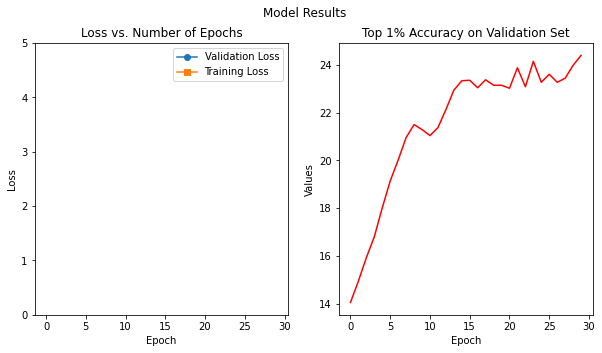

In [7]:

model = to_device(Net1(), device)
history = [evaluate(model, val_loader)]
num_epochs = 30
opt_func = torch.optim.Adam
lr = 3e-4
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)
histories.append(history)
plotResults(history[1:], "Net1")


In [37]:
 with torch.no_grad():
    count = 0
    lim = 0
    for batch in train_dl:
        print(len(batch))
        print(batch[1].shape)
        count+=1

        if count > lim:
            break
    

2
torch.Size([8, 250])


In [14]:
limit = 100;
counter = 0
truthVal = []
pred = []
while counter < limit:
    dataInput, out  = train_data[counter]
    for val in out:
        truthVal.append(float(val))
    inputVal = dataInput.float()
    modelres = model(inputVal.to("cuda"))
    for res in modelres:
        pred.append(float(res))
    counter+=1

plt.figure()
plt.plot(truthVal, "-r")
plt.plot(pred)
plt.show()


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [64, 1278, 3], but got 2-dimensional input of size [1278, 400] instead